In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from utils import mnist
import numpy as np

In [2]:
PATH = './FashionMNIST'

In [3]:
ds = datasets.FashionMNIST(PATH, download=True)

In [4]:
data = ds.train_data.view(-1).float() / 255
m = data.mean()
s = data.std()
m, s 

(tensor(0.2860), tensor(0.3530))

In [5]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((m,), (s,))
])

In [6]:
train_ds = datasets.FashionMNIST(PATH, transform=tfms, download=True, train=True)
test_ds = datasets.FashionMNIST(PATH, transform=tfms, download=True, train=False)

In [7]:
train_loader = DataLoader(train_ds, batch_size=60)
test_loader = DataLoader(test_ds, batch_size=60)

In [8]:
class Net(nn.Module):
    def __init__(self, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 10)
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [9]:
def train(epoch, model):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        model.optim.zero_grad()
        output = model(data.cuda())
        loss = model.loss(output, target.cuda())
        loss.backward()
        model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss {:.6f}'.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader), model._loss.item())
            print(line)    
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss  {:.6f}'.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader), model._loss.item())
        print(line)
    return model._loss.item()

In [10]:
def test(model, loader):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda l, c, p: ' ' + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.cuda()
            target = target.cuda()
            output = model(data)
            test_loss += model.loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            pred = pred.cpu()
            correct += pred.eq(target.data.cpu().view_as(pred)).cpu().sum()
    
    test_loss /= test_size
    correct_pct = 100. * correct / test_size
    report = 'Test set:\n' + line(test_loss, correct, correct_pct) + '\n'
    
    print(report)
    return test_loss

In [11]:
trn_losses = []
tst_losses = []
with torch.cuda.device(6) as d:
    model = Net().cuda()
    for epoch in range(1, 21):
        model.train()
        l = train(epoch, model)
        trn_losses.append(l)
        model.eval()
        l = test(model, test_loader)
        tst_losses.append(l)
        

Train Epoch: 1 [0/60000 (0%)]	Loss 2.302072
Train Epoch: 1 [12000/60000 (20%)]	Loss 0.390284
Train Epoch: 1 [24000/60000 (40%)]	Loss 0.768342
Train Epoch: 1 [36000/60000 (60%)]	Loss 0.580555
Train Epoch: 1 [48000/60000 (80%)]	Loss 0.388972
Train Epoch: 1 [60000/60000 (100%)]	Loss  0.346640
Test set:
 Loss: 0.4337	Accuracy: 8427/10000 (84%)

Train Epoch: 2 [0/60000 (0%)]	Loss 0.290698
Train Epoch: 2 [12000/60000 (20%)]	Loss 0.226135
Train Epoch: 2 [24000/60000 (40%)]	Loss 0.629939
Train Epoch: 2 [36000/60000 (60%)]	Loss 0.498736
Train Epoch: 2 [48000/60000 (80%)]	Loss 0.412274
Train Epoch: 2 [60000/60000 (100%)]	Loss  0.294235
Test set:
 Loss: 0.3809	Accuracy: 8606/10000 (86%)

Train Epoch: 3 [0/60000 (0%)]	Loss 0.218914
Train Epoch: 3 [12000/60000 (20%)]	Loss 0.192709
Train Epoch: 3 [24000/60000 (40%)]	Loss 0.568168
Train Epoch: 3 [36000/60000 (60%)]	Loss 0.434477
Train Epoch: 3 [48000/60000 (80%)]	Loss 0.405460
Train Epoch: 3 [60000/60000 (100%)]	Loss  0.276345
Test set:
 Loss: 0.3552

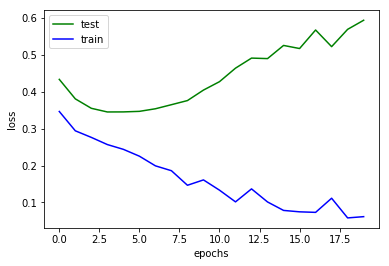

In [12]:
import matplotlib.pyplot as plt
plt.plot(tst_losses, color='green', label="test")
plt.plot(trn_losses, color='blue', label="train")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.show()
